# Predicting Video Game Sales
First of all, we need to import some libraries.

In [168]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp

#import visuals as vs
import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset 1 (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

## Dataset 2 (ign.csv)
This is my secondary dataset. It might be used to support the primary dataset, but this would probably require major effort for merging both.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| ID              | ID                                                            | Numeric   |
| score_phrase    | Game rating as a phrase                                       | String    |
| title           | Name of the game                                              | String    |
| url             | URL to source of data                                         | String    |
| platform        | Platform                                                      | String    |
| score           | Game rating as a float                                        | Numeric   |
| genre           | Genre                                                         | String    |
| editors_choice  | Special recommendation of the editor                          | String    |
| release_year    | Year of release                                               | Numeric   |
| release_month   | Month of release                                              | Numeric   |
| release_day     | Day of release                                                | Numeric   |


We can remove several colums in dataset2 that we don't need:
* **ID** which is just an ID that's not used in dataset 1
* **score_phrase**, because it redundant to _score_ and less precise
* **url**, because that's just the origin of the data
The next step will be to load the datasets.

In [169]:
# Load dataset #1
try:
    dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")
    print "Dataset #1 has {} samples with {} features.".format(*dataset1.shape)
except:
    print "Dataset #1 could not be loaded. Is the dataset missing?"

print('\n')

Dataset #1 has 16719 samples with 16 features.




In [170]:
# Display a description of the datasets
display(dataset1.dtypes)
display(dataset1.head())
display(dataset1.tail())
display(dataset1.describe())
print('\n')

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16718,Winning Post 8 2016,PSV,2016.0,Simulation,Tecmo Koei,0.00,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [171]:
# Sanitization

# beautify strings and kick 
for i in range(0, len(dataset1.axes[1])):
    if (dataset1.ix[:,i].dtype == object):
        dataset1.ix[:,i] = dataset1.ix[:,i].str.strip()

# tbd to NaN
dataset1 = dataset1.replace('tbd', float('NaN'))

# Remove rows with empty values, we want full information
for column in dataset1.axes[1]:
    dataset1 = dataset1[dataset1[column].notnull()]

# correct data types
dataset1['User_Score'] = dataset1['User_Score'].apply(pd.to_numeric)
    
# dataset1 is now clean, make a copy for possibe use later
clean_dataset1 = dataset1.copy()

# display some infos
display(clean_dataset1.head())
print ('REMAINING ROWS IN DATASET #1: {}'.format(*clean_dataset1.shape))
print ('Dataset #1 has {} unique game name values'.format(clean_dataset1['Name'].unique().size))
print ('Dataset #1 has {} unique platforms values'.format(clean_dataset1['Platform'].unique().size))
print ('Dataset #1 has games from {} unique years'.format(clean_dataset1['Year_of_Release'].unique().size))
print ('Dataset #1 has {} unique genre values'.format(clean_dataset1['Genre'].unique().size))
print ('Dataset #1 has {} unique publisher values'.format(clean_dataset1['Publisher'].unique().size))
print ('Dataset #1 has {} unique developer values'.format(clean_dataset1['Developer'].unique().size))
print ('Dataset #1 has {} unique rating values'.format(clean_dataset1['Rating'].unique().size))

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


REMAINING ROWS IN DATASET #1: 6825
Dataset #1 has 4377 unique game name values
Dataset #1 has 17 unique platforms values
Dataset #1 has games from 25 unique years
Dataset #1 has 12 unique genre values
Dataset #1 has 261 unique publisher values
Dataset #1 has 1289 unique developer values
Dataset #1 has 7 unique rating values


In [172]:
# extract possible target values (sales volume)
sales = pd.DataFrame()
sales['Global'] = clean_dataset1['Global_Sales'].copy()
sales['NA'] = clean_dataset1['NA_Sales'].copy()
sales['EU'] = clean_dataset1['EU_Sales'].copy()
sales['JP'] = clean_dataset1['JP_Sales'].copy()
sales['Other'] = clean_dataset1['Other_Sales'].copy()

In [173]:
# Feature Generation and further harmonizing data

# make a short dataset that will contain all rows considered for further analysis
short_dataset1 = clean_dataset1.copy()

# remove target columns
short_dataset1 = short_dataset1.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)

# => too many unique values per feature for the dataset size, so features should be removed
short_dataset1 = short_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)

# create Boolean columns for each remaining nominal variable
for platform in short_dataset1['Platform'].unique():
    short_dataset1['Platform_' + platform] = short_dataset1['Platform'].map(lambda x: True if x == platform else False)

for genre in short_dataset1['Genre'].unique():
    short_dataset1['Genre_' + genre] = short_dataset1['Genre'].map(lambda x: True if x == genre else False) 

for rating in short_dataset1['Rating'].unique():
    short_dataset1['Rating_' + rating] = short_dataset1['Rating'].map(lambda x: True if x == rating else False)

# Platform manufacturer based on the platform
man_microsoft = ['PC','X360','XB','XOne']
man_nintendo  = ['3DS','DS','GBA','GC','N64','Wii','WiiU']
man_sega      = ['DC']
man_sony      = ['PS','PS2','PS3','PS4' ,'PSP','PSV']

short_dataset1['Platform_Manufacturer'] = short_dataset1['Platform'].map(lambda x:
    'Microsoft' if x in man_microsoft else
    'Nintendo' if x in man_nintendo else
    'Sega' if x in man_sega else
    'Sony' if x in man_sony else
    float('NaN'))

# Portable based on the platform
portables = ['3DS','DS','GBA','PSP','PSV']

short_dataset1['Portable'] = short_dataset1['Platform'].map(lambda x: True if x in portables else False)

# remove old columns
short_dataset1 = short_dataset1.drop(['Platform', 'Genre', 'Rating'], axis=1)

# Scale User_Score to boundaries of Critic_Score
short_dataset1[['User_Score']] = short_dataset1[['User_Score']] * 10

display(short_dataset1.head())
print ('REMAINING ROWS IN DATASET #1: {}'.format(*short_dataset1.shape))
print ('Dataset #1 has games from {} unique years'.format(short_dataset1['Year_of_Release'].unique().size))

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Platform_Wii,Platform_DS,Platform_X360,Platform_PS3,Platform_PS2,...,Genre_Strategy,Rating_E,Rating_M,Rating_T,Rating_E10+,Rating_AO,Rating_K-A,Rating_RP,Platform_Manufacturer,Portable
0,2006.0,76.0,51.0,80.0,322.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
2,2008.0,82.0,73.0,83.0,709.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
3,2009.0,80.0,73.0,80.0,192.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
6,2006.0,89.0,65.0,85.0,431.0,False,True,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,True
7,2006.0,58.0,41.0,66.0,129.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False


REMAINING ROWS IN DATASET #1: 6825
Dataset #1 has games from 25 unique years


In [174]:
# Outliers

# There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
# I consider the those earlier rows to be outliers to be removed
short_dataset1 = short_dataset1[short_dataset1.Year_of_Release > 1999]

# display some infos
display(short_dataset1.head())
print ('REMAINING ROWS IN DATASET #1: {}'.format(*short_dataset1.shape))
print ('Dataset #1 has games from {} unique years'.format(short_dataset1['Year_of_Release'].unique().size))

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Platform_Wii,Platform_DS,Platform_X360,Platform_PS3,Platform_PS2,...,Genre_Strategy,Rating_E,Rating_M,Rating_T,Rating_E10+,Rating_AO,Rating_K-A,Rating_RP,Platform_Manufacturer,Portable
0,2006.0,76.0,51.0,80.0,322.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
2,2008.0,82.0,73.0,83.0,709.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
3,2009.0,80.0,73.0,80.0,192.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
6,2006.0,89.0,65.0,85.0,431.0,False,True,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,True
7,2006.0,58.0,41.0,66.0,129.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False


REMAINING ROWS IN DATASET #1: 6746
Dataset #1 has games from 17 unique years


In [175]:
# Show correlations between all variables
display(short_dataset1.corr()[short_dataset1.corr() > 0.7])
# display(short_dataset1.corr())

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Platform_Wii,Platform_DS,Platform_X360,Platform_PS3,Platform_PS2,...,Genre_Adventure,Genre_Strategy,Rating_E,Rating_M,Rating_T,Rating_E10+,Rating_AO,Rating_K-A,Rating_RP,Portable
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critic_Score,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critic_Count,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_Score,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_Count,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform_Wii,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform_DS,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform_X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform_PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform_PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to understand the dataset better, we should have a look at possible values.

In [176]:
# stats
print('MEDIAN')
display(short_dataset1.median())
print('STANDARD DEVIATION')
display(short_dataset1.std())

# TODO: Check for outliers, see below visually

MEDIAN


Year_of_Release       2007.0
Critic_Score            72.0
Critic_Count            25.0
User_Score              75.0
User_Count              27.0
Platform_Wii             0.0
Platform_DS              0.0
Platform_X360            0.0
Platform_PS3             0.0
Platform_PS2             0.0
Platform_3DS             0.0
Platform_PS4             0.0
Platform_PS              0.0
Platform_XB              0.0
Platform_PC              0.0
Platform_PSP             0.0
Platform_WiiU            0.0
Platform_GC              0.0
Platform_GBA             0.0
Platform_XOne            0.0
Platform_PSV             0.0
Platform_DC              0.0
Genre_Sports             0.0
Genre_Racing             0.0
Genre_Platform           0.0
Genre_Misc               0.0
Genre_Action             0.0
Genre_Puzzle             0.0
Genre_Shooter            0.0
Genre_Fighting           0.0
Genre_Simulation         0.0
Genre_Role-Playing       0.0
Genre_Adventure          0.0
Genre_Strategy           0.0
Rating_E      

STANDARD DEVIATION


Year_of_Release         4.091946
Critic_Score           13.829731
Critic_Count           19.242673
User_Score             14.383981
User_Count            584.894703
Platform_Wii            0.256852
Platform_DS             0.253101
Platform_X360           0.333206
Platform_PS3            0.317827
Platform_PS2            0.374770
Platform_3DS            0.149840
Platform_PS4            0.184874
Platform_PS             0.111549
Platform_XB             0.277038
Platform_PC             0.293058
Platform_PSP            0.233405
Platform_WiiU           0.114109
Platform_GC             0.221206
Platform_GBA            0.184127
Platform_XOne           0.151715
Platform_PSV            0.131105
Platform_DC             0.040351
Genre_Sports            0.346483
Genre_Racing            0.279253
Genre_Platform          0.235361
Genre_Misc              0.231144
Genre_Action            0.427111
Genre_Puzzle            0.130008
Genre_Shooter           0.333372
Genre_Fighting          0.227409
Genre_Simu

In [177]:
# TESTING: OUTLIER DETECTION

OUTLIER_THRESHOLD = 1.5

# For each feature find the data points with extreme high or low values

# TODO: CHECK FOR MULTIPLE OUTLIERS

outliers = []
for feature in short_dataset1.keys():
    if short_dataset1[feature].dtype == float:

        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = short_dataset1[feature].quantile(0.25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = short_dataset1[feature].quantile(0.75)

        # Use the interquartile range to calculate an outlier step (OUTLIER_THRESHOLD times the interquartile range)
        step = (Q3 - Q1) * OUTLIER_THRESHOLD

        # Display the outlier count
        print "Data points considered outliers for the feature '{}': {}".format(feature, short_dataset1[~((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))].shape[0])
        # outliers.extend(short_dataset1[~((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))].index.values)

        # remove outliers
        short_dataset1 = short_dataset1[((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))]
display(short_dataset1.describe())
display(short_dataset1.head())

Data points considered outliers for the feature 'Year_of_Release': 0
Data points considered outliers for the feature 'Critic_Score': 105
Data points considered outliers for the feature 'Critic_Count': 160
Data points considered outliers for the feature 'User_Score': 197
Data points considered outliers for the feature 'User_Count': 840


,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count
count,5444.000000,5444.000000,5444.000000,5444.000000,5444.000000
mean,2006.960140,69.393644,25.671749,73.222814,36.520389
std,3.897746,12.026591,15.369970,11.610659,39.131032
min,2000.000000,35.000000,3.000000,40.000000,4.000000
25%,2004.000000,62.000000,14.000000,66.000000,9.000000
50%,2007.000000,71.000000,23.000000,75.000000,21.000000
75%,2010.000000,78.250000,35.000000,82.000000,47.000000
max,2016.000000,97.000000,77.000000,96.000000,184.000000


,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Platform_Wii,Platform_DS,Platform_X360,Platform_PS3,Platform_PS2,...,Genre_Strategy,Rating_E,Rating_M,Rating_T,Rating_E10+,Rating_AO,Rating_K-A,Rating_RP,Platform_Manufacturer,Portable
7,2006.0,58.0,41.0,66.0,129.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
13,2007.0,80.0,63.0,77.0,146.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
14,2010.0,61.0,45.0,63.0,106.0,False,False,True,False,False,...,False,True,False,False,False,False,False,False,Microsoft,False
15,2009.0,80.0,33.0,74.0,52.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,False
19,2005.0,77.0,58.0,79.0,50.0,False,True,False,False,False,...,False,True,False,False,False,False,False,False,Nintendo,True


Also, Plots will probably help ...

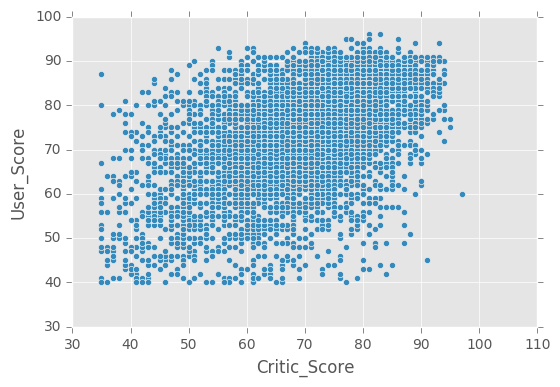

In [178]:
# Critic_Score and User_Score
short_dataset1.plot.scatter(x='Critic_Score', y='User_Score')

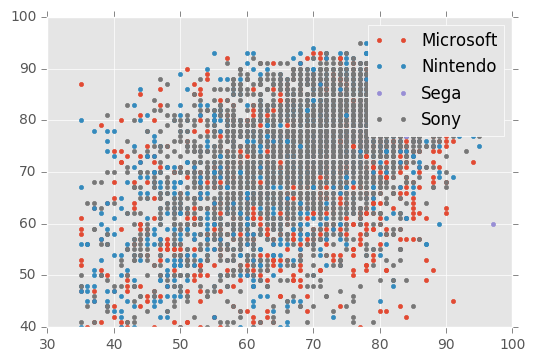

In [179]:
# Just for testing
groups = short_dataset1.groupby('Platform_Manufacturer')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)
ax.legend()

plt.show()

In [180]:
# Don't forget ...
# vs.ModelLearning(...) from external file
# vs.ModelComplexity(...) from external file in customer_segments